#World Optimization
Name: William Ona

#Series Time Machine Leaning - Electricity demand

In [1]:
!pip install skforecast

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 343.8/343.8 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 11.7 MB/s eta 0:00:00
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.65.0
    Uninstalling tqdm-4.65.0:
      Successfully uninstalled tqdm-4.65.0


Libraries

In [19]:
import numpy as np
import pandas as pd

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import plotly.express as px
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth']=1.5
%matplotlib inline


In [21]:
from lightgbm import LGBMRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster, backtesting_forecaster

In [23]:
import warnings
warnings.filterwarnings('ignore')

##Data Preprocessing

In [137]:
data = pd.read_csv('vic_elec.csv')
data.info( )

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52608 entries, 0 to 52607
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Time         52608 non-null  object 
 1   Demand       52608 non-null  float64
 2   Temperature  52608 non-null  float64
 3   Date         52608 non-null  object 
 4   Holiday      52608 non-null  bool   
dtypes: bool(1), float64(2), object(2)
memory usage: 1.7+ MB


In [138]:
data.head()

,Time,Demand,Temperature,Date,Holiday
0,2011-12-31T13:00:00Z,4382.825174,21.40,2012-01-01,True
1,2011-12-31T13:30:00Z,4263.365526,21.05,2012-01-01,True
2,2011-12-31T14:00:00Z,4048.966046,20.70,2012-01-01,True
3,2011-12-31T14:30:00Z,3877.563330,20.55,2012-01-01,True
4,2011-12-31T15:00:00Z,4036.229746,20.40,2012-01-01,True


Format type of Time

In [139]:
data['Time'] = pd.to_datetime(data['Time'], format = '%Y-%m-%dT%H:%M:%SZ')
data = data.set_index('Time')
data = data.asfreq('30min')
data = data.sort_index()

In [140]:
data = data.drop(columns='Date')
data = data.resample(rule='H', closed='left',label = 'right').mean()

Dataset has "Holiday" variable that indicates whether a particular day is a holiday or not, split the holiday days into separate dummy variables.

In [141]:
data['day_week']= data.index.dayofweek
data = pd.get_dummies(data, columns=['day_week'])

In [142]:
data.head(5)

,Demand,Temperature,Holiday,day_week_0,day_week_1,day_week_2,day_week_3,day_week_4,day_week_5,day_week_6
Time,,,,,,,,,,
2011-12-31 14:00:00,4323.095350,21.225,1.0,0,0,0,0,0,1,0
2011-12-31 15:00:00,3963.264688,20.625,1.0,0,0,0,0,0,1,0
2011-12-31 16:00:00,3950.913495,20.325,1.0,0,0,0,0,0,1,0
2011-12-31 17:00:00,3627.860675,19.850,1.0,0,0,0,0,0,1,0
2011-12-31 18:00:00,3396.251676,19.025,1.0,0,0,0,0,0,1,0


In [143]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26304 entries, 2011-12-31 14:00:00 to 2014-12-31 13:00:00
Freq: H
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Demand       26304 non-null  float64
 1   Temperature  26304 non-null  float64
 2   Holiday      26304 non-null  float64
 3   day_week_0   26304 non-null  uint8  
 4   day_week_1   26304 non-null  uint8  
 5   day_week_2   26304 non-null  uint8  
 6   day_week_3   26304 non-null  uint8  
 7   day_week_4   26304 non-null  uint8  
 8   day_week_5   26304 non-null  uint8  
 9   day_week_6   26304 non-null  uint8  
dtypes: float64(3), uint8(7)
memory usage: 1001.8 KB


##Split Dataset into trainning, validation and test

In [146]:
#training-validation-test
data = data.loc['2013-01-01 00:00:00': '2014-03-31 23:00:00']
fin_train = '2013-12-31 23:59:00'
fin_validation = '2014-02-28 23:59:00'
data_train = data.loc[: fin_train, :] #un ano
data_val = data.loc[ fin_train: fin_validation, :]
data_test = data.loc[fin_validation:, :]
print(f'Date train : {data_train.index.min()}...{data_train.index.max()}...(n={len(data_train)})')
print(f'Date validation : {data_val.index.min()}...{data_val.index.max()}...(n={len(data_val)})')
print(f'Date test : {data_test.index.min()}...{data_test.index.max()}...(n={len(data_test)})')

Date train : 2013-01-01 00:00:00...2013-12-31 23:00:00...(n=8760)
Date validation : 2014-01-01 00:00:00...2014-02-28 23:00:00...(n=1416)
Date test : 2014-03-01 00:00:00...2014-03-31 23:00:00...(n=744)


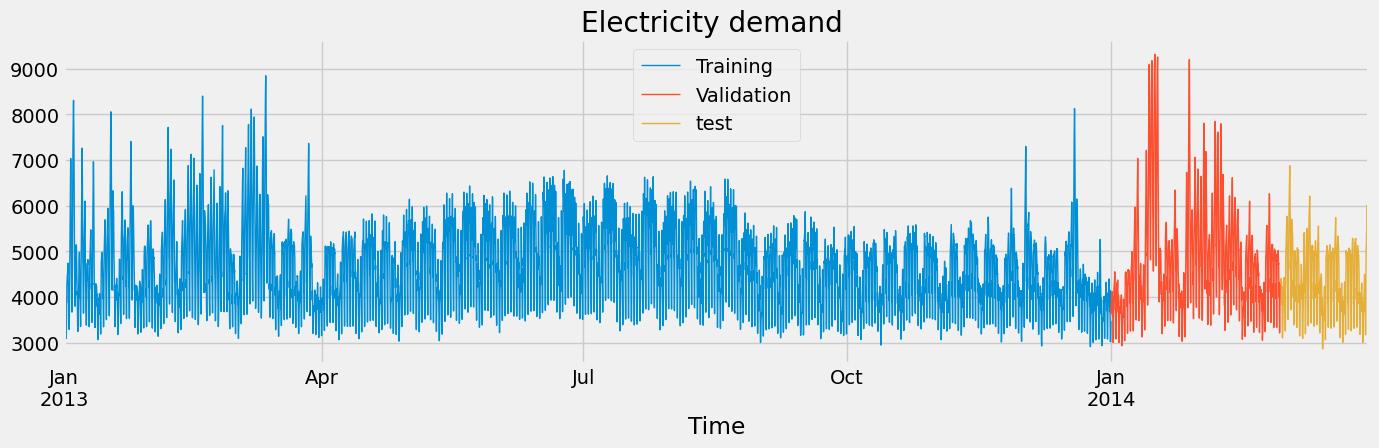

In [104]:
fig, ax = plt.subplots(figsize=(15,4))
data_train.Demand.plot(ax=ax,label='Training',linewidth=1)
data_val.Demand.plot(ax=ax, label='Validation', linewidth=1)
data_test.Demand.plot(ax=ax, label='test', linewidth=1)
ax.set_title('Electricity demand ')
ax.legend();

In [107]:
data.loc[:fin_train,'partition']= 'train'
data.loc[fin_train:fin_validation,'partition']= 'validation'
data.loc[fin_validation:,'partition']= 'test'
fig = px.line(data_frame = data.reset_index(), x= 'Time', y='Demand', color = 'partition', title = 'Number of user', width=1200, height =500)
fig.show()

In [109]:
data= data.drop(columns='partition')

## Autocorrelation ACF and  PACF

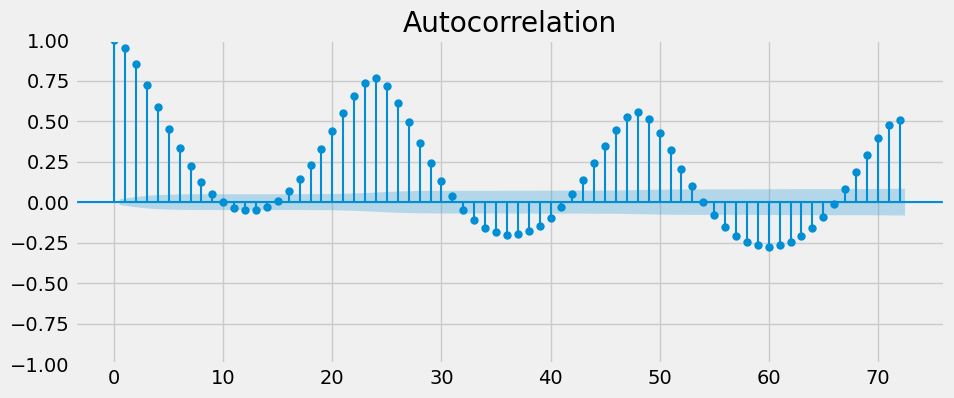

In [110]:
fig, ax = plt.subplots(figsize=(10,4))
plot_acf(data.Demand, ax=ax, lags=72)
plt.show()

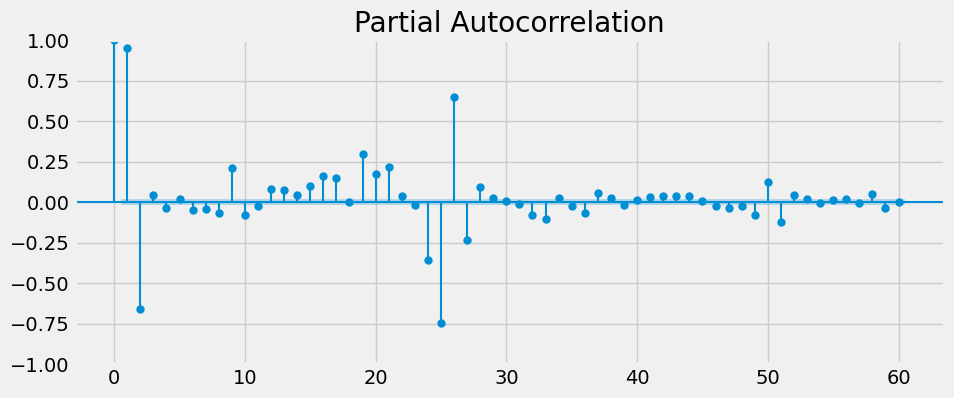

In [111]:
fig, ax = plt.subplots(figsize=(10,4))
plot_pacf(data.Demand, ax=ax , lags=60)
plt.show()

###Holiday vs Working day

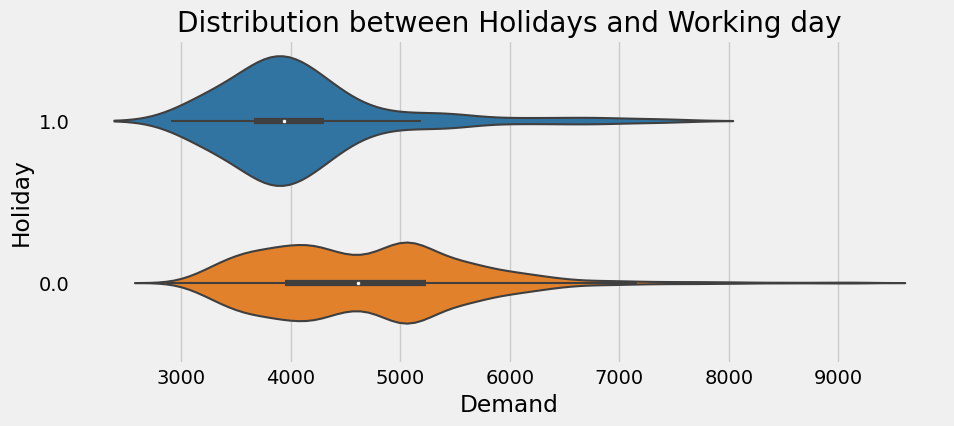

In [112]:
fig, ax = plt.subplots(figsize =(10,4))
sns.violinplot(x='Demand', y= 'Holiday', data= data.assign( Holiday = data.Holiday.astype(str)), palette='tab10', ax=ax)
ax.set_title('Distribution between Holidays and Working day')
ax.set_xlabel('Demand')
ax.set_ylabel('Holiday');

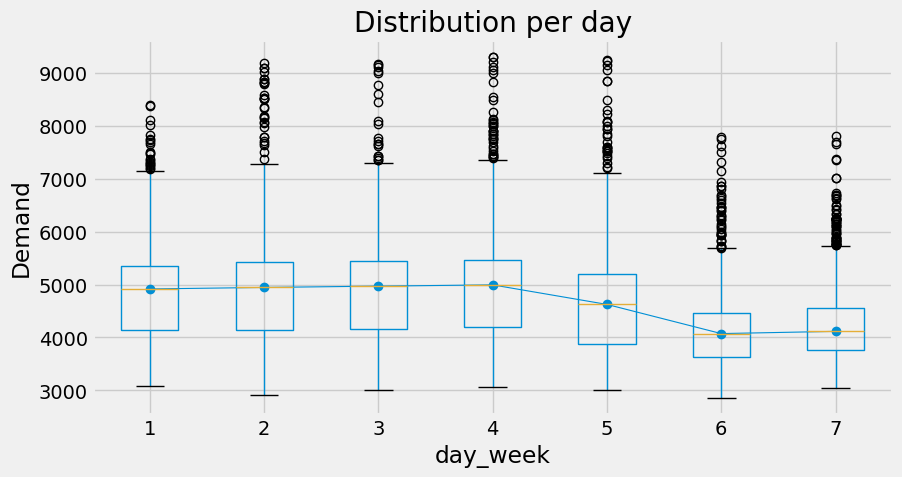

In [114]:
fig,ax = plt.subplots(figsize=(10,5))
data['day_week']= data.index.day_of_week +1
data.boxplot(column= 'Demand', by= 'day_week', ax=ax)
data.groupby('day_week')['Demand'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title('Distribution per day')
fig.suptitle('');

##Recursive model

In [115]:
forecaster = ForecasterAutoreg(regressor = LGBMRegressor(max_depth=2, learning_rate=0.1, n_estimators=50),lags = 24)
forecaster

ForecasterAutoreg 
Regressor: LGBMRegressor(max_depth=2, n_estimators=50) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: None 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 2, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 50, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0} 
Creation date: 2023-05-09 04:39:07 
Last fit date: None 
Skforecast version: 0.7.0 
Python version: 3.10.11 
Fore

In [116]:
forecaster.fit(y=data.loc[:fin_validation,'Demand']) #train+validation
forecaster

ForecasterAutoreg 
Regressor: LGBMRegressor(max_depth=2, n_estimators=50) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: None 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2013-01-01 00:00:00'), Timestamp('2014-02-28 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 2, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 50, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0} 
Creation date: 2023-05-09 04:39:07 
Last fi

In [117]:
predicciones = forecaster.predict(steps=24)
predicciones

2014-03-01 00:00:00    4408.239985
2014-03-01 01:00:00    4411.637620
2014-03-01 02:00:00    4428.275942
2014-03-01 03:00:00    4428.275942
2014-03-01 04:00:00    4428.275942
2014-03-01 05:00:00    4453.031145
2014-03-01 06:00:00    4502.396654
2014-03-01 07:00:00    4533.849776
2014-03-01 08:00:00    4470.718270
2014-03-01 09:00:00    4454.053199
2014-03-01 10:00:00    4374.121904
2014-03-01 11:00:00    4322.575298
2014-03-01 12:00:00    4257.833678
2014-03-01 13:00:00    4116.380853
2014-03-01 14:00:00    4099.874124
2014-03-01 15:00:00    3864.827750
2014-03-01 16:00:00    3712.459307
2014-03-01 17:00:00    3649.035300
2014-03-01 18:00:00    3603.119251
2014-03-01 19:00:00    3579.913964
2014-03-01 20:00:00    3722.008709
2014-03-01 21:00:00    3881.450058
2014-03-01 22:00:00    4032.745788
2014-03-01 23:00:00    4227.064922
Freq: H, Name: pred, dtype: float64

In [118]:
from matplotlib.widgets import RangeSlider
data_plot = pd.DataFrame({'test': data_test['Demand'], 'prediction': predicciones})
data_plot.index.name = 'Time'
fig = px.line( data_frame = data_plot.reset_index(), x ='Time',y= data_plot.columns, title = 'Electricity Demand', width =1200, height =500)
fig.update_xaxes(rangeslider_visible =True)
fig.show()

###Backtesting

In [121]:
metrica , prediction = backtesting_forecaster(forecaster= forecaster, y = data['Demand'], initial_train_size =  len(data.loc[: fin_validation]), steps=24 , metric = 'mean_absolute_error', refit=False, verbose =True)

Information of backtesting process
----------------------------------
Number of observations used for initial training: 10176
Number of observations used for backtesting: 744
    Number of folds: 31
    Number of steps per fold: 24

Data partition in fold: 0
    Training:   2013-01-01 00:00:00 -- 2014-02-28 23:00:00  (n=10176)
    Validation: 2014-03-01 00:00:00 -- 2014-03-01 23:00:00  (n=24)
Data partition in fold: 1
    Training:   2013-01-01 00:00:00 -- 2014-02-28 23:00:00  (n=10176)
    Validation: 2014-03-02 00:00:00 -- 2014-03-02 23:00:00  (n=24)
Data partition in fold: 2
    Training:   2013-01-01 00:00:00 -- 2014-02-28 23:00:00  (n=10176)
    Validation: 2014-03-03 00:00:00 -- 2014-03-03 23:00:00  (n=24)
Data partition in fold: 3
    Training:   2013-01-01 00:00:00 -- 2014-02-28 23:00:00  (n=10176)
    Validation: 2014-03-04 00:00:00 -- 2014-03-04 23:00:00  (n=24)
Data partition in fold: 4
    Training:   2013-01-01 00:00:00 -- 2014-02-28 23:00:00  (n=10176)
    Validation: 201

In [122]:
print(f"Backtest error: {metrica}")

Backtest error: 389.78858120441265


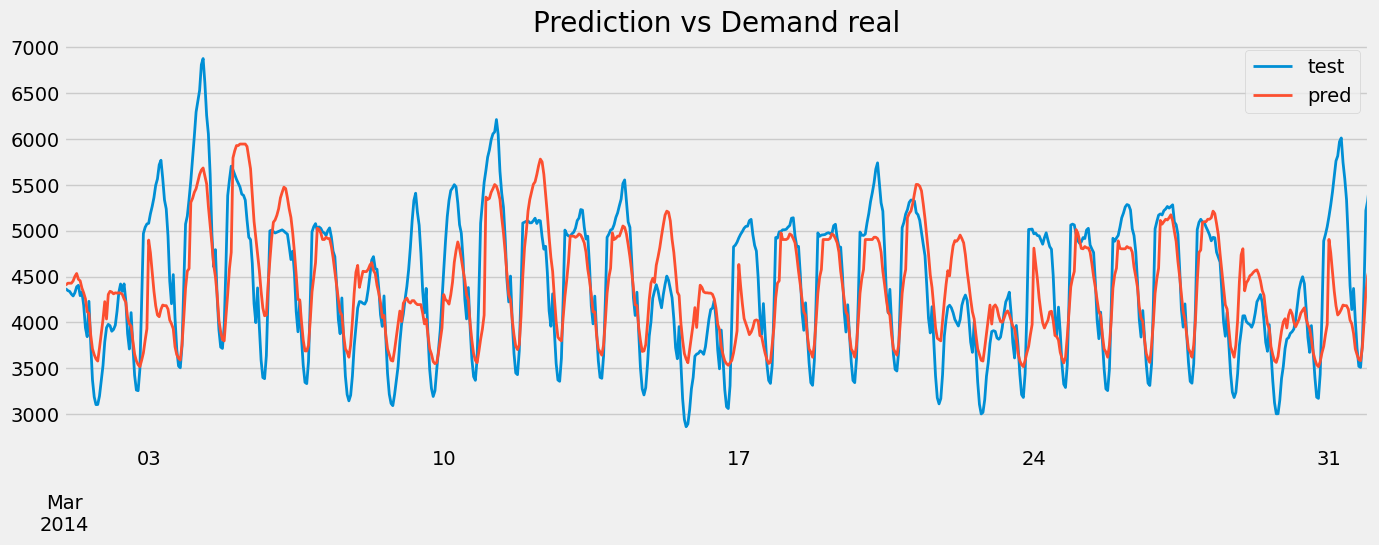

In [123]:
from seaborn._core.properties import LineWidth
fig, ax = plt.subplots(figsize=(15,5))
data.loc[prediction.index, 'Demand'].plot(ax=ax, linewidth= 2, label='test')
prediction.plot(linewidth=2, label='prediccion',ax=ax)
ax.set_title('Prediction vs Demand real')
ax.legend();

In [124]:
data_plot = pd.DataFrame({'test': data_test['Demand'], 'prediction': prediction['pred']})
data_plot.index.name = 'Time'
fig = px.line( data_frame = data_plot.reset_index(), x ='Time',y= data_plot.columns, title = 'Electricity Demand', width =1200, height =500)
fig.update_xaxes(rangeslider_visible =True)
fig.show()

In [125]:
metrica , prediction = backtesting_forecaster(forecaster= forecaster, y = data['Demand'], initial_train_size =  len(data.loc[: fin_validation]), steps=24 ,interval= [5,95], n_boot =100, metric = 'mean_absolute_error', refit=False, verbose =True)

Information of backtesting process
----------------------------------
Number of observations used for initial training: 10176
Number of observations used for backtesting: 744
    Number of folds: 31
    Number of steps per fold: 24

Data partition in fold: 0
    Training:   2013-01-01 00:00:00 -- 2014-02-28 23:00:00  (n=10176)
    Validation: 2014-03-01 00:00:00 -- 2014-03-01 23:00:00  (n=24)
Data partition in fold: 1
    Training:   2013-01-01 00:00:00 -- 2014-02-28 23:00:00  (n=10176)
    Validation: 2014-03-02 00:00:00 -- 2014-03-02 23:00:00  (n=24)
Data partition in fold: 2
    Training:   2013-01-01 00:00:00 -- 2014-02-28 23:00:00  (n=10176)
    Validation: 2014-03-03 00:00:00 -- 2014-03-03 23:00:00  (n=24)
Data partition in fold: 3
    Training:   2013-01-01 00:00:00 -- 2014-02-28 23:00:00  (n=10176)
    Validation: 2014-03-04 00:00:00 -- 2014-03-04 23:00:00  (n=24)
Data partition in fold: 4
    Training:   2013-01-01 00:00:00 -- 2014-02-28 23:00:00  (n=10176)
    Validation: 201

In [126]:
prediction.head()

,pred,lower_bound,upper_bound
2014-03-01 00:00:00,4408.239985,4183.497545,4843.586109
2014-03-01 01:00:00,4411.637620,4103.665543,4891.975972
2014-03-01 02:00:00,4428.275942,4058.072597,5025.745031
2014-03-01 03:00:00,4428.275942,4100.655514,5152.241464
2014-03-01 04:00:00,4428.275942,4064.580785,5191.880580


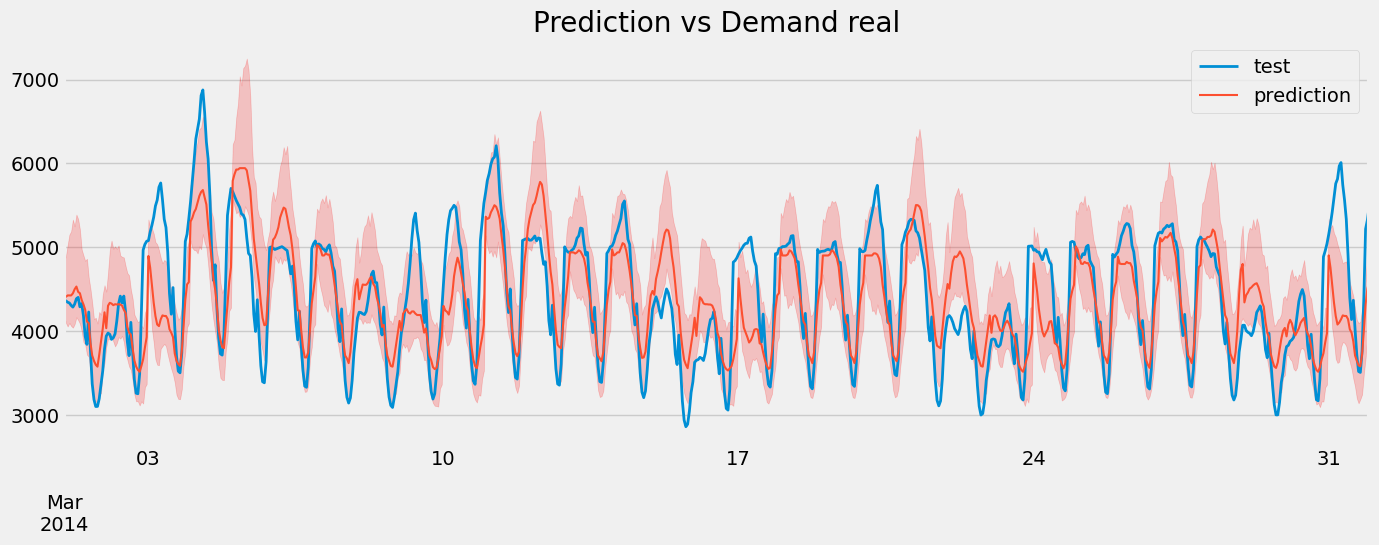

In [127]:
fig, ax = plt.subplots(figsize=(15,5))
data.loc[predicciones.index, 'Demand'].plot(ax=ax, linewidth= 2, label='test')
prediction['pred'].plot(label='prediction',ax=ax)
ax.fill_between(prediction.index, prediction['lower_bound'], prediction['upper_bound'], color='red', alpha=0.2)
ax.set_title('Prediction vs Demand real')
ax.legend();

###Tunning

In [128]:
param_grid = { 'max_iter': [100,500], 'max_depth':[3,10],'learning_rate': [0.01, 1]}
lags_grid = [24,48,[1,2,24]]
result_grid = grid_search_forecaster(forecaster = forecaster, y = data.loc[:fin_validation,'Demand'], param_grid= param_grid, lags_grid=lags_grid, steps=24 , refit= False, metric = 'mean_absolute_error', initial_train_size = int(len(datos_train)), return_best= True, verbose=False)

Number of models compared: 24.


loop param_grid:   0%|                                              | 0/8 [00:00<?, ?it/s]

[LightGBM] [Warning] num_iterations is set=100, max_iter=100 will be ignored. Current value: num_iterations=100



loop param_grid:  12%|████▊                                 | 1/8 [00:00<00:02,  2.34it/s]

[LightGBM] [Warning] num_iterations is set=500, max_iter=500 will be ignored. Current value: num_iterations=500



loop param_grid:  25%|█████████▌                            | 2/8 [00:01<00:04,  1.34it/s]

[LightGBM] [Warning] num_iterations is set=100, max_iter=100 will be ignored. Current value: num_iterations=100



loop param_grid:  38%|██████████████▎                       | 3/8 [00:02<00:03,  1.40it/s]

[LightGBM] [Warning] num_iterations is set=500, max_iter=500 will be ignored. Current value: num_iterations=500



loop param_grid:  50%|███████████████████                   | 4/8 [00:04<00:05,  1.32s/it]

[LightGBM] [Warning] num_iterations is set=100, max_iter=100 will be ignored. Current value: num_iterations=100



loop param_grid:  62%|███████████████████████▊              | 5/8 [00:04<00:02,  1.02it/s]

[LightGBM] [Warning] num_iterations is set=500, max_iter=500 will be ignored. Current value: num_iterations=500



loop param_grid:  75%|████████████████████████████▌         | 6/8 [00:05<00:01,  1.08it/s]

[LightGBM] [Warning] num_iterations is set=100, max_iter=100 will be ignored. Current value: num_iterations=100



loop param_grid:  88%|█████████████████████████████████▎    | 7/8 [00:06<00:00,  1.25it/s]

[LightGBM] [Warning] num_iterations is set=500, max_iter=500 will be ignored. Current value: num_iterations=500



loop param_grid:   0%|                                              | 0/8 [00:00<?, ?it/s]

[LightGBM] [Warning] num_iterations is set=100, max_iter=100 will be ignored. Current value: num_iterations=100



loop param_grid:  12%|████▊                                 | 1/8 [00:00<00:03,  2.05it/s]

[LightGBM] [Warning] num_iterations is set=500, max_iter=500 will be ignored. Current value: num_iterations=500



loop param_grid:  25%|█████████▌                            | 2/8 [00:01<00:05,  1.02it/s]

[LightGBM] [Warning] num_iterations is set=100, max_iter=100 will be ignored. Current value: num_iterations=100



loop param_grid:  38%|██████████████▎                       | 3/8 [00:04<00:09,  1.89s/it]

[LightGBM] [Warning] num_iterations is set=500, max_iter=500 will be ignored. Current value: num_iterations=500



loop param_grid:  50%|███████████████████                   | 4/8 [00:08<00:10,  2.62s/it]

[LightGBM] [Warning] num_iterations is set=100, max_iter=100 will be ignored. Current value: num_iterations=100



loop param_grid:  62%|███████████████████████▊              | 5/8 [00:09<00:05,  1.85s/it]

[LightGBM] [Warning] num_iterations is set=500, max_iter=500 will be ignored. Current value: num_iterations=500



loop param_grid:  75%|████████████████████████████▌         | 6/8 [00:10<00:03,  1.61s/it]

[LightGBM] [Warning] num_iterations is set=100, max_iter=100 will be ignored. Current value: num_iterations=100



loop param_grid:  88%|█████████████████████████████████▎    | 7/8 [00:10<00:01,  1.33s/it]

[LightGBM] [Warning] num_iterations is set=500, max_iter=500 will be ignored. Current value: num_iterations=500



loop param_grid:   0%|                                              | 0/8 [00:00<?, ?it/s]

[LightGBM] [Warning] num_iterations is set=100, max_iter=100 will be ignored. Current value: num_iterations=100



loop param_grid:  12%|████▊                                 | 1/8 [00:00<00:02,  3.38it/s]

[LightGBM] [Warning] num_iterations is set=500, max_iter=500 will be ignored. Current value: num_iterations=500



loop param_grid:  25%|█████████▌                            | 2/8 [00:02<00:09,  1.59s/it]

[LightGBM] [Warning] num_iterations is set=100, max_iter=100 will be ignored. Current value: num_iterations=100



loop param_grid:  38%|██████████████▎                       | 3/8 [00:03<00:05,  1.03s/it]

[LightGBM] [Warning] num_iterations is set=500, max_iter=500 will be ignored. Current value: num_iterations=500



loop param_grid:  50%|███████████████████                   | 4/8 [00:04<00:04,  1.03s/it]

[LightGBM] [Warning] num_iterations is set=100, max_iter=100 will be ignored. Current value: num_iterations=100



loop param_grid:  62%|███████████████████████▊              | 5/8 [00:04<00:02,  1.30it/s]

[LightGBM] [Warning] num_iterations is set=500, max_iter=500 will be ignored. Current value: num_iterations=500



loop param_grid:  75%|████████████████████████████▌         | 6/8 [00:05<00:01,  1.43it/s]

[LightGBM] [Warning] num_iterations is set=100, max_iter=100 will be ignored. Current value: num_iterations=100



loop param_grid:  88%|█████████████████████████████████▎    | 7/8 [00:05<00:00,  1.70it/s]

[LightGBM] [Warning] num_iterations is set=500, max_iter=500 will be ignored. Current value: num_iterations=500



loop lags_grid: 100%|███████████████████████████████████████| 3/3 [00:27<00:00,  9.24s/it]


[LightGBM] [Warning] num_iterations is set=500, max_iter=500 will be ignored. Current value: num_iterations=500
`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
  Parameters: {'learning_rate': 0.01, 'max_depth': 10, 'max_iter': 500}
  Backtesting metric: 451.8432748910177



In [130]:
result_grid.head(10)

,lags,params,mean_absolute_error,learning_rate,max_depth,max_iter
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_depth': 10, 'max_...",451.843275,0.01,10.0,500.0
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_depth': 3, 'max_i...",463.348019,0.01,3.0,500.0
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_depth': 10, 'max_...",472.088451,0.01,10.0,500.0
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 1, 'max_depth': 3, 'max_iter...",535.120159,1.00,3.0,500.0
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 1, 'max_depth': 3, 'max_iter...",540.206670,1.00,3.0,100.0
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_depth': 3, 'max_i...",540.256443,0.01,3.0,500.0
14,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 1, 'max_depth': 10, 'max_ite...",542.037930,1.00,10.0,100.0
15,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 1, 'max_depth': 10, 'max_ite...",543.567942,1.00,10.0,500.0
12,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 1, 'max_depth': 3, 'max_iter...",568.399881,1.00,3.0,100.0
19,"[1, 2, 24]","{'learning_rate': 0.01, 'max_depth': 10, 'max_...",570.015507,0.01,10.0,500.0


In [131]:
metric , prediction = backtesting_forecaster(forecaster= forecaster, y = data.Demand, initial_train_size =  len(data.loc[: fin_validation]), steps=24 , metric = 'mean_absolute_error', refit=False, verbose =True)
print(f"Backtest error: {metric}")

[LightGBM] [Warning] num_iterations is set=500, max_iter=500 will be ignored. Current value: num_iterations=500
Information of backtesting process
----------------------------------
Number of observations used for initial training: 10176
Number of observations used for backtesting: 744
    Number of folds: 31
    Number of steps per fold: 24

Data partition in fold: 0
    Training:   2013-01-01 00:00:00 -- 2014-02-28 23:00:00  (n=10176)
    Validation: 2014-03-01 00:00:00 -- 2014-03-01 23:00:00  (n=24)
Data partition in fold: 1
    Training:   2013-01-01 00:00:00 -- 2014-02-28 23:00:00  (n=10176)
    Validation: 2014-03-02 00:00:00 -- 2014-03-02 23:00:00  (n=24)
Data partition in fold: 2
    Training:   2013-01-01 00:00:00 -- 2014-02-28 23:00:00  (n=10176)
    Validation: 2014-03-03 00:00:00 -- 2014-03-03 23:00:00  (n=24)
Data partition in fold: 3
    Training:   2013-01-01 00:00:00 -- 2014-02-28 23:00:00  (n=10176)
    Validation: 2014-03-04 00:00:00 -- 2014-03-04 23:00:00  (n=24)
Dat

###Exogenous variable 

In [132]:
forecaster = ForecasterAutoreg(regressor = LGBMRegressor(max_depth=10, learning_rate=0.01, n_estimators=500),lags = 48)
forecaster

ForecasterAutoreg 
Regressor: LGBMRegressor(learning_rate=0.01, max_depth=10, n_estimators=500) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
Transformer for y: None 
Transformer for exog: None 
Window size: 48 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.01, 'max_depth': 10, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0} 
Creation date: 

In [144]:
variables_exog = ['Holiday','day_week_0', 'day_week_1','day_week_2','day_week_3','day_week_4','day_week_5','day_week_6']
forecaster.fit( y=data.loc[:fin_validation, 'Demand'], exog =  data.loc[:fin_validation, variables_exog])
forecaster

ForecasterAutoreg 
Regressor: LGBMRegressor(learning_rate=0.01, max_depth=10, n_estimators=500) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
Transformer for y: None 
Transformer for exog: None 
Window size: 48 
Weight function included: False 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['Holiday', 'day_week_0', 'day_week_1', 'day_week_2', 'day_week_3', 'day_week_4', 'day_week_5', 'day_week_6'] 
Training range: [Timestamp('2011-12-31 14:00:00'), Timestamp('2014-02-28 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.01, 'max_depth': 10, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jo

In [147]:
exog_next_24h = data_test[variables_exog][:24]
prediction = forecaster.predict(steps=24, exog = exog_next_24h)
prediction

2014-03-01 00:00:00    4272.445862
2014-03-01 01:00:00    4258.150547
2014-03-01 02:00:00    4220.377075
2014-03-01 03:00:00    4206.467426
2014-03-01 04:00:00    4208.539404
2014-03-01 05:00:00    4256.046377
2014-03-01 06:00:00    4313.599629
2014-03-01 07:00:00    4357.362757
2014-03-01 08:00:00    4372.989378
2014-03-01 09:00:00    4328.918156
2014-03-01 10:00:00    4303.414824
2014-03-01 11:00:00    4200.264000
2014-03-01 12:00:00    4010.671042
2014-03-01 13:00:00    3922.348841
2014-03-01 14:00:00    4139.255442
2014-03-01 15:00:00    3778.248465
2014-03-01 16:00:00    3488.806745
2014-03-01 17:00:00    3295.066072
2014-03-01 18:00:00    3213.030861
2014-03-01 19:00:00    3266.735505
2014-03-01 20:00:00    3382.188714
2014-03-01 21:00:00    3633.735486
2014-03-01 22:00:00    3958.235672
2014-03-01 23:00:00    4165.632958
Freq: H, Name: pred, dtype: float64

In [148]:
metric , prediction = backtesting_forecaster(forecaster= forecaster, y = data['Demand'], exog = data[variables_exog], initial_train_size =  len(data.loc[: fin_validation]), steps=24 , metric = 'mean_absolute_error', refit=False, verbose =True)
print(f"Backtest error: {metric}")

Information of backtesting process
----------------------------------
Number of observations used for initial training: 10176
Number of observations used for backtesting: 744
    Number of folds: 31
    Number of steps per fold: 24

Data partition in fold: 0
    Training:   2013-01-01 00:00:00 -- 2014-02-28 23:00:00  (n=10176)
    Validation: 2014-03-01 00:00:00 -- 2014-03-01 23:00:00  (n=24)
Data partition in fold: 1
    Training:   2013-01-01 00:00:00 -- 2014-02-28 23:00:00  (n=10176)
    Validation: 2014-03-02 00:00:00 -- 2014-03-02 23:00:00  (n=24)
Data partition in fold: 2
    Training:   2013-01-01 00:00:00 -- 2014-02-28 23:00:00  (n=10176)
    Validation: 2014-03-03 00:00:00 -- 2014-03-03 23:00:00  (n=24)
Data partition in fold: 3
    Training:   2013-01-01 00:00:00 -- 2014-02-28 23:00:00  (n=10176)
    Validation: 2014-03-04 00:00:00 -- 2014-03-04 23:00:00  (n=24)
Data partition in fold: 4
    Training:   2013-01-01 00:00:00 -- 2014-02-28 23:00:00  (n=10176)
    Validation: 201

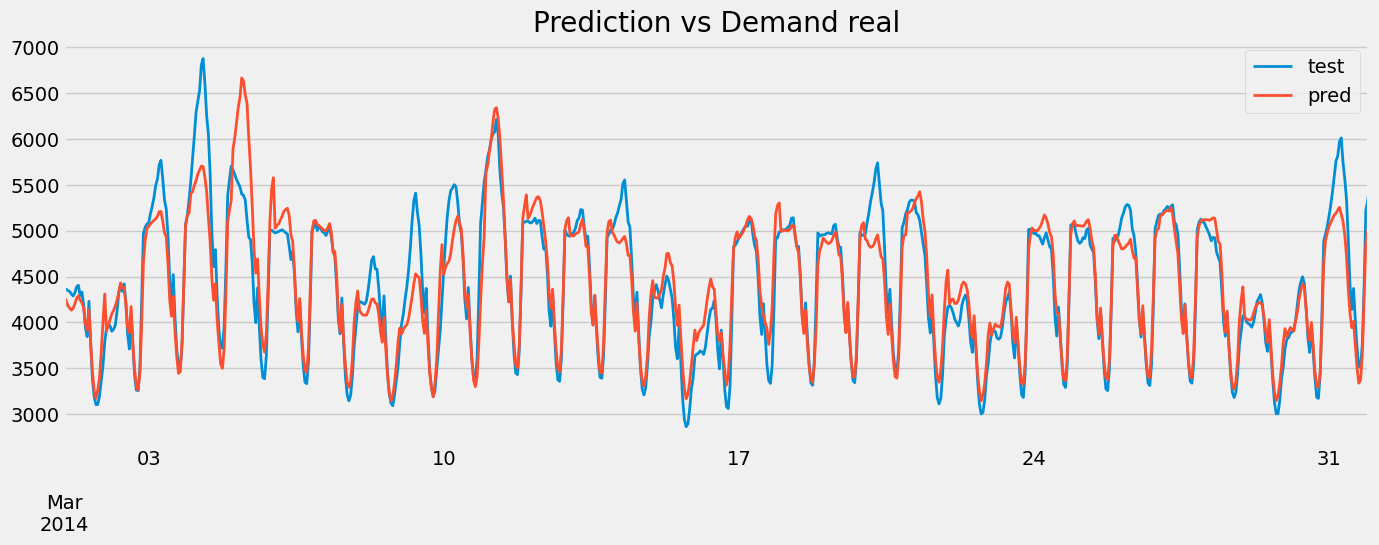

In [149]:
fig, ax = plt.subplots(figsize=(15,5))
data.loc[prediction.index, 'Demand'].plot(ax=ax, linewidth= 2, label='test')
prediction.plot(linewidth=2, label='prediction',ax=ax)
ax.set_title('Prediction vs Demand real')
ax.legend();

###Prediction importance

In [150]:
forecaster.get_feature_importance().sort_values('importance', ascending=False)

,feature,importance
0,lag_1,3192
23,lag_24,1318
25,lag_26,1091
24,lag_25,1001
22,lag_23,762
2,lag_3,508
1,lag_2,494
26,lag_27,429
8,lag_9,347
20,lag_21,277


###Modeling with hyperparameter tuning

In [151]:
forecaster.fit(y=data.loc[:fin_validation,'Demand'])
forecaster

ForecasterAutoreg 
Regressor: LGBMRegressor(learning_rate=0.01, max_depth=10, n_estimators=500) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
Transformer for y: None 
Transformer for exog: None 
Window size: 48 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2013-01-01 00:00:00'), Timestamp('2014-02-28 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.01, 'max_depth': 10, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1

In [152]:
prediction = forecaster.predict(steps=24)
prediction.head()

2014-03-01 00:00:00    4283.322577
2014-03-01 01:00:00    4248.728778
2014-03-01 02:00:00    4195.733596
2014-03-01 03:00:00    4175.552597
2014-03-01 04:00:00    4166.865569
Freq: H, Name: pred, dtype: float64

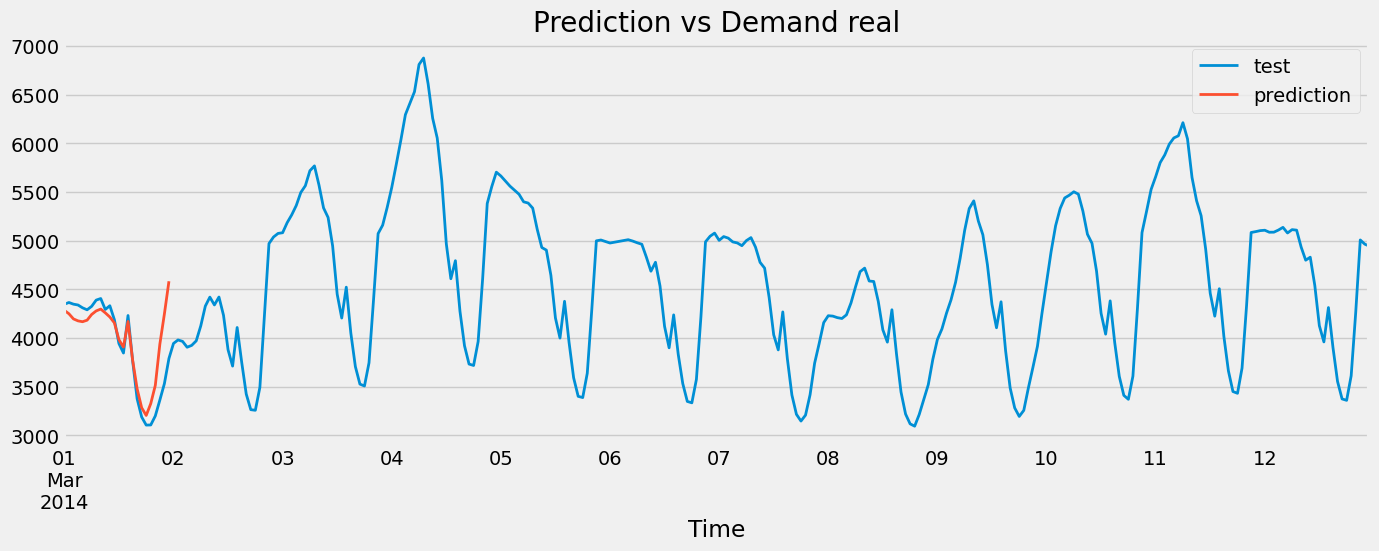

In [153]:
fig, ax = plt.subplots(figsize=(15,5))
data_test.loc[:'2014-03-12 23:00:00', 'Demand'].plot(ax=ax, linewidth= 2, label='test')
prediction.plot(linewidth=2, label='prediction',ax=ax)
ax.set_title('Prediction vs Demand real')
ax.legend();

In [154]:
data_last_48h = data.loc['2014-03-08 00:00:00':'2014-03-09 23:00:00','Demand']
prediction = forecaster.predict(steps=24, last_window= data_last_48h)
prediction.head()

2014-03-10 00:00:00    4494.321409
2014-03-10 01:00:00    4593.987302
2014-03-10 02:00:00    4640.411843
2014-03-10 03:00:00    4672.999342
2014-03-10 04:00:00    4756.821106
Freq: H, Name: pred, dtype: float64

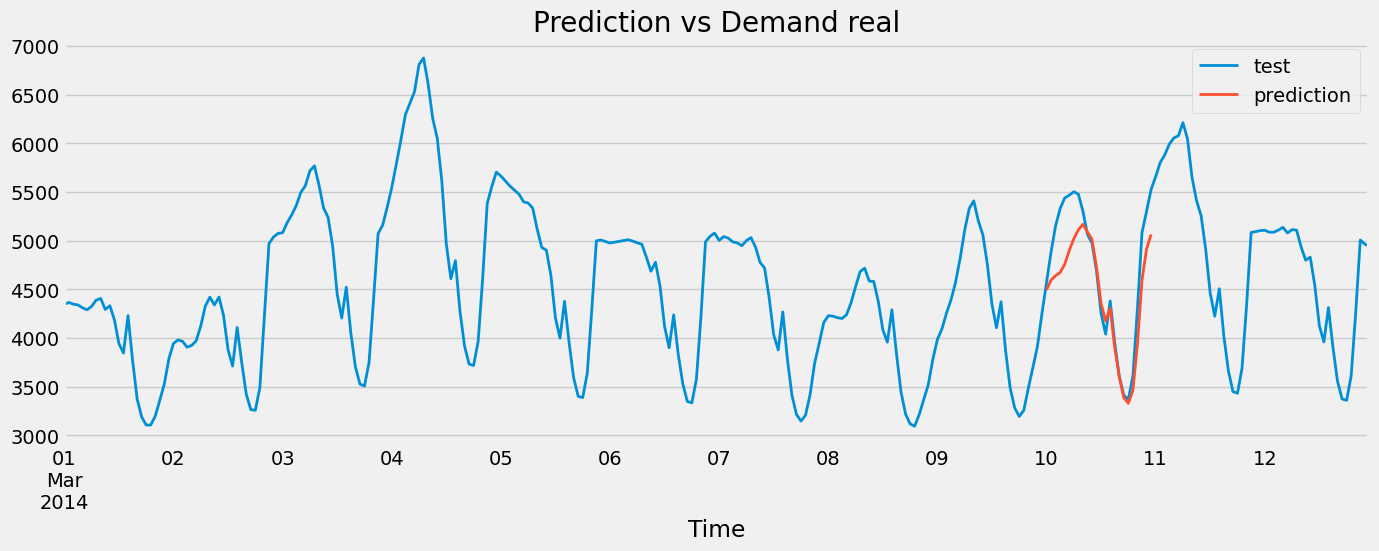

In [155]:
fig, ax = plt.subplots(figsize=(15,5))
data_test.loc[:'2014-03-12 23:00:00', 'Demand'].plot(ax=ax, linewidth= 2, label='test')
prediction.plot(linewidth=2, label='prediction',ax=ax)
ax.set_title('Prediction vs Demand real')
ax.legend();